In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import  r2_score, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
df = pd.read_csv('../data/Housing.csv')

# EDA

In [4]:
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [5]:
print(f"Dataset shape: {df.shape}")

print(df.info())

Dataset shape: (545, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


In [6]:
# Check if there are any missing values in the DataFrame
print("Missing values in the DataFrame?", df.isna().any().any())

Missing values in the DataFrame? False


In [7]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


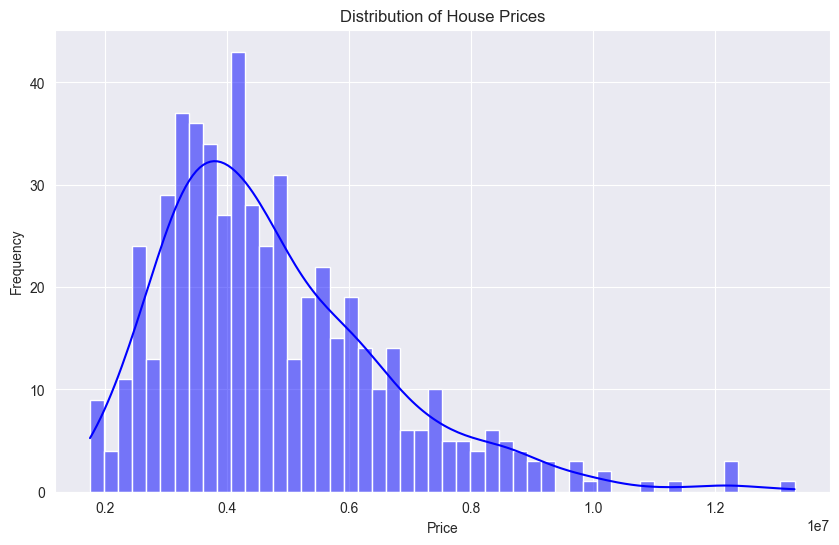

In [8]:
# Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

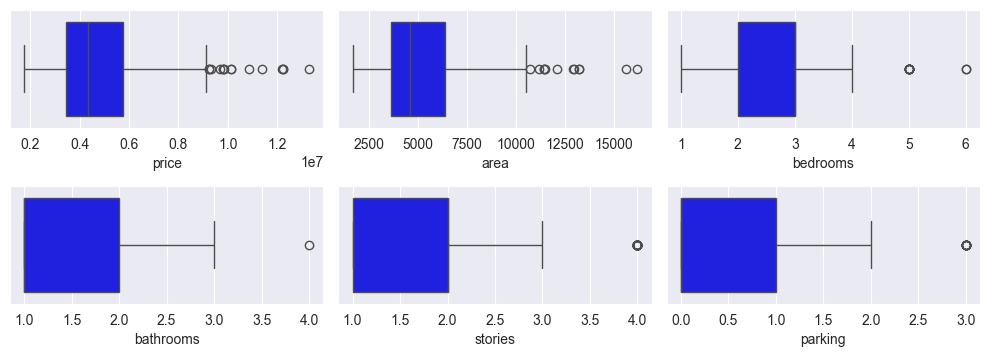

In [9]:
#Check the ouliers using boxplot
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 5))

for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col], color='blue')

plt.tight_layout()
plt.show()

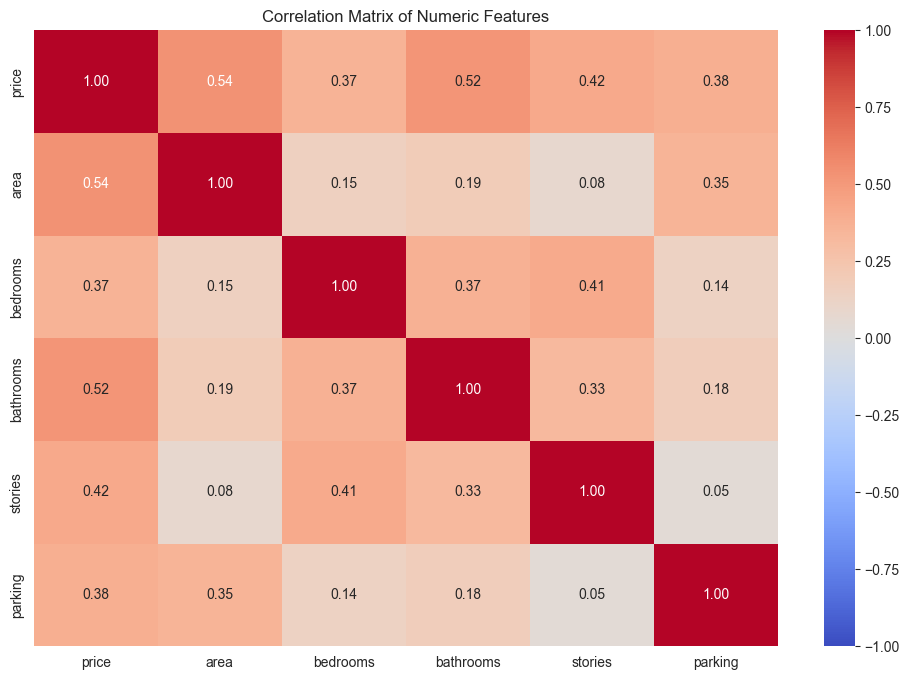

In [10]:
# Correlation matrix for numeric features
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Preprocessing

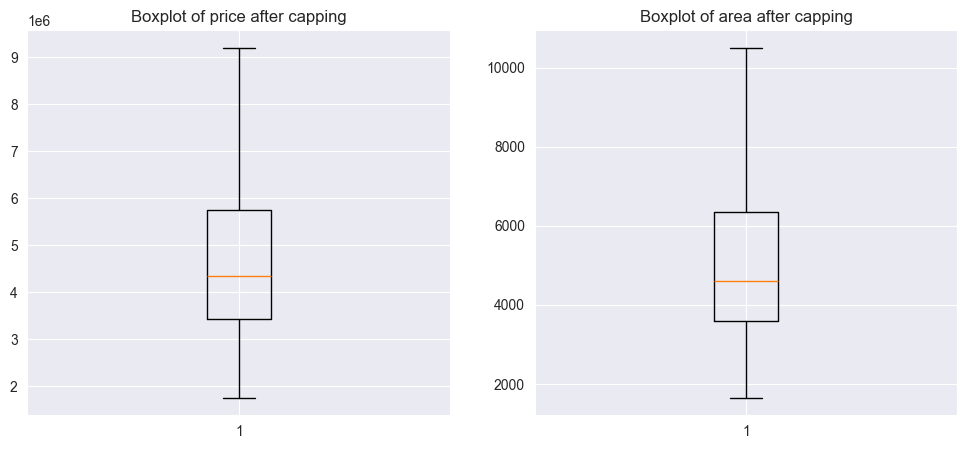

In [11]:
# capping outliers
columns_to_cap = ['price', 'area']

for col in columns_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(columns_to_cap):
    axes[i].boxplot(df[col])
    axes[i].set_title(f'Boxplot of {col} after capping')

plt.show()

In [12]:
# Load and preprocess data
target = 'price'
X = df.drop(target, axis=1)
y = df[target]
X = pd.get_dummies(X, drop_first=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
X_train

array([[0.49152542, 0.4       , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.62711864, 0.4       , 0.33333333, ..., 0.        , 1.        ,
        0.        ],
       [0.24474576, 0.2       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3220339 , 0.4       , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.2700565 , 0.2       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.43502825, 0.4       , 0.33333333, ..., 0.        , 1.        ,
        0.        ]])

In [15]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Model

In [16]:
class HousePricePredictor(nn.Module):
    def __init__(self, input_size, hidden1=256, hidden2=128, hidden3=64, dropout_rate=0.1):
        super(HousePricePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden3, 1)
        )

    def forward(self, x):
        return self.model(x)

In [17]:
# Hyperparameter tuning options
best_r2 = -np.inf
best_params = {}
learning_rates = [0.001, 0.005, 0.01, 0.1, 0.11, 0.12]
hidden_sizes = [(128, 64, 32), (256, 128, 64),(512, 128, 64),(512, 256, 64),(512, 256, 128), (64, 32, 16)]

In [18]:
# Hyperparameter tuning loop
for lr in learning_rates:
    for hidden1, hidden2, hidden3 in hidden_sizes:
        # Initialize model, loss, optimizer, and scheduler
        model = HousePricePredictor(X_train.shape[1], hidden1, hidden2, hidden3).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

        num_epochs = 5000
        train_losses, val_losses = [], []
        best_val_loss = np.inf
        patience = 100
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                train_losses.append(loss.item())
                val_losses.append(val_loss.item())

            scheduler.step(val_loss)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                break

        # Evaluate performance
        with torch.no_grad():
            y_pred = model(X_val).cpu().numpy()
            y_true = y_val.cpu().numpy()
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Track the best model
        if r2 > best_r2:
            best_r2 = r2
            best_params = {'lr': lr, 'hidden1': hidden1, 'hidden2': hidden2, 'hidden3': hidden3}
            best_model = model

# Model Evaluation

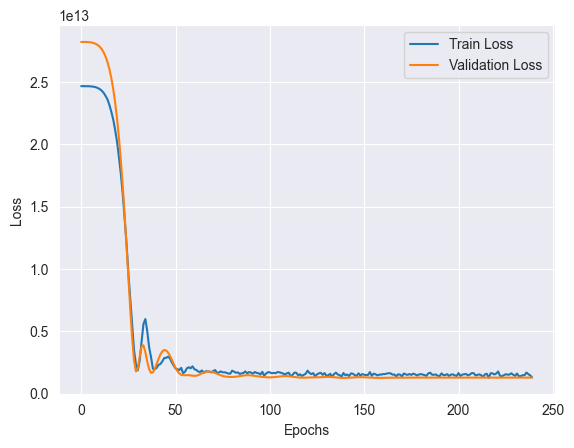

Best Hyperparameters: {'lr': 0.01, 'hidden1': 512, 'hidden2': 256, 'hidden3': 128}
Best R²: 0.6959
Best RMSE: 1137041.6876


In [19]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Best Hyperparameters: {best_params}')
print(f'Best R²: {best_r2:.4f}')
print(f'Best RMSE: {rmse:.4f}')

Training RMSE: 961970.6792, Training R²: 0.6670
Validation RMSE: 1108476.2753, Validation R²: 0.6959


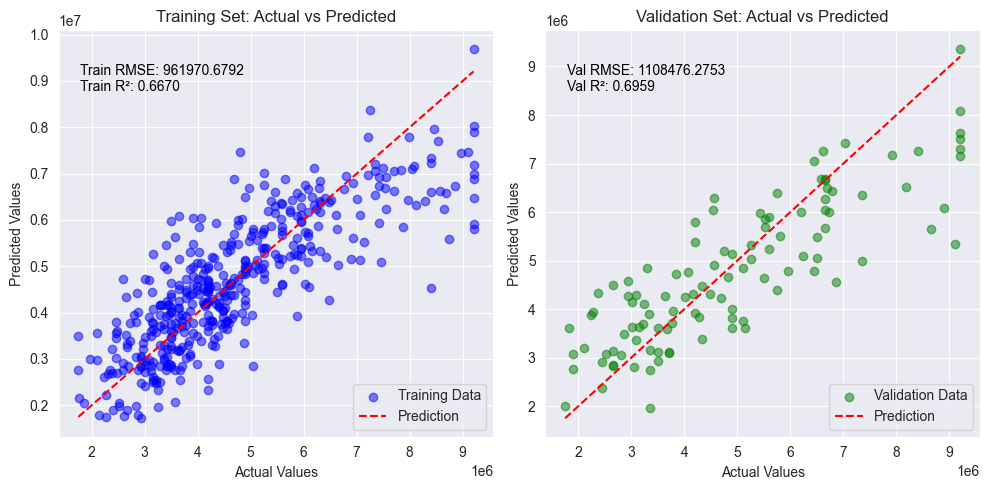

In [20]:
# After training loop
best_model.eval()  # Set the best model to evaluation mode

# Compute predictions for training and validation sets
with torch.no_grad():
    # Training set
    y_train_pred = best_model(X_train).cpu().numpy()
    y_train_true = y_train.cpu().numpy()

    # Validation set
    y_val_pred = best_model(X_val).cpu().numpy()
    y_val_true = y_val.cpu().numpy()

# Calculate RMSE and R² for training set
train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
train_r2 = r2_score(y_train_true, y_train_pred)

# Calculate RMSE and R² for validation set
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
val_r2 = r2_score(y_val_true, y_val_pred)

# Print the evaluation metrics
print(f'Training RMSE: {train_rmse:.4f}, Training R²: {train_r2:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}, Validation R²: {val_r2:.4f}')

# Create the actual vs predicted graph
plt.figure(figsize=(10, 5))

# Plot training set
plt.subplot(1, 2, 1)
plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Training Data', color='blue')
plt.plot([min(y_train_true), max(y_train_true)], [min(y_train_true), max(y_train_true)],
         color='red', linestyle='--', label='Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: Actual vs Predicted')
plt.annotate(f'Train RMSE: {train_rmse:.4f}\nTrain R²: {train_r2:.4f}',
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
plt.legend()

# Plot validation set
plt.subplot(1, 2, 2)
plt.scatter(y_val_true, y_val_pred, alpha=0.5, label='Validation Data', color='green')
plt.plot([min(y_val_true), max(y_val_true)], [min(y_val_true), max(y_val_true)],
         color='red', linestyle='--', label='Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Validation Set: Actual vs Predicted')
plt.annotate(f'Val RMSE: {val_rmse:.4f}\nVal R²: {val_r2:.4f}',
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
best_model_path = '../model/best_model.pth'
torch.save(best_model.state_dict(), best_model_path)
print(f'Best model saved to {best_model_path}')

Best model saved to ../model/best_model.pth
